In [1]:
# define root path
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


In [2]:
# load metadata from excel sheet
from src.load_data import load_metadata

DATA_DIR = Path("../data/MODMA")

meta = load_metadata(DATA_DIR / "subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx")

print(meta.columns)
meta.head()


Index(['type', 'age', 'gender', 'education（years）', 'PHQ-9', 'CTQ-SF', 'LES',
       'SSRS', 'GAD-7', 'PSQI', 'subject_id'],
      dtype='object')


,type,age,gender,education（years）,PHQ-9,CTQ-SF,LES,SSRS,GAD-7,PSQI,subject_id
0,MDD,18,F,12,23,77,-143,31,18,12,02010002
1,MDD,25,F,19,12,53,-44,38,13,11,02010004
2,MDD,20,M,16,19,49,-3,28,11,5,02010005
3,MDD,42,M,16,16,59,-30,40,12,9,02010006
4,MDD,42,M,12,17,66,-71,44,18,13,02010008


In [3]:
# load a sample subject's data
from src.load_data import load_subject

sample_mat = DATA_DIR / "02030020_rest 20151230 1416.mat" 
raw, label, info = load_subject(sample_mat, meta)

print(info)
print("label:", label)
print("shape:", raw.get_data().shape)
print("sfreq:", raw.info["sfreq"])


{'subject_id': '02030020', 'sfreq': 250.0, 'mat_key': 'a02030020_rest_20151230_1416mat', 'file': '02030020_rest 20151230 1416.mat', 'type': 'HC', 'PHQ-9': np.int64(5)}
label: 0
shape: (128, 75127)
sfreq: 250.0


Using matplotlib as 2D backend.


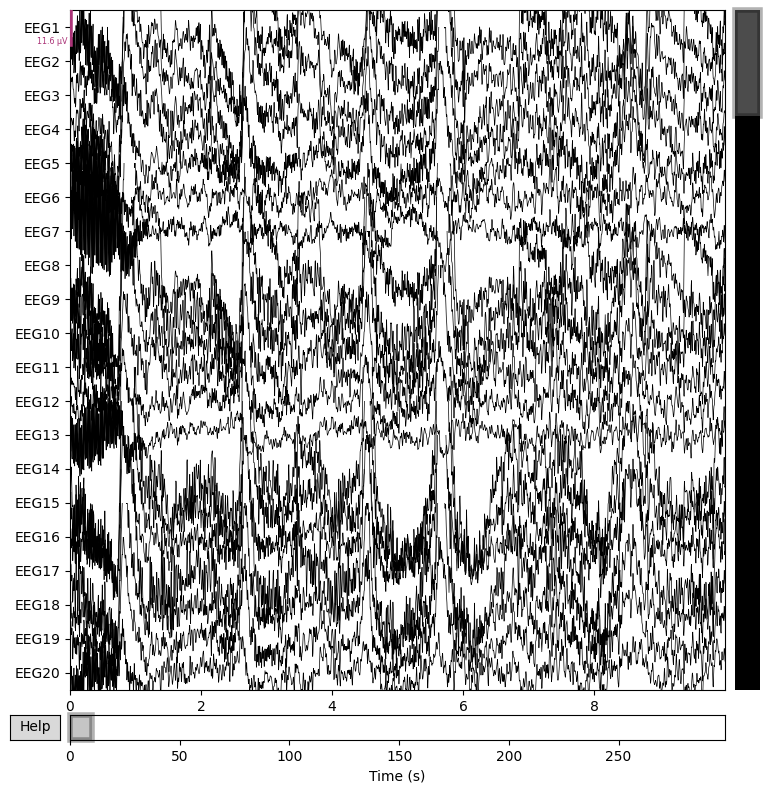

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/var/folders/0k/hp671l_10pgf05sz2tbx1g600000gn/T/ipykernel_52416/1277787594.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_clean.compute_psd(fmax = 50).plot()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


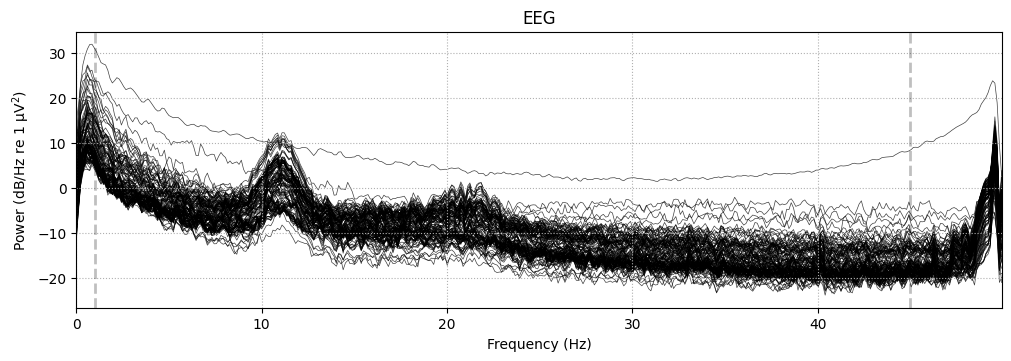

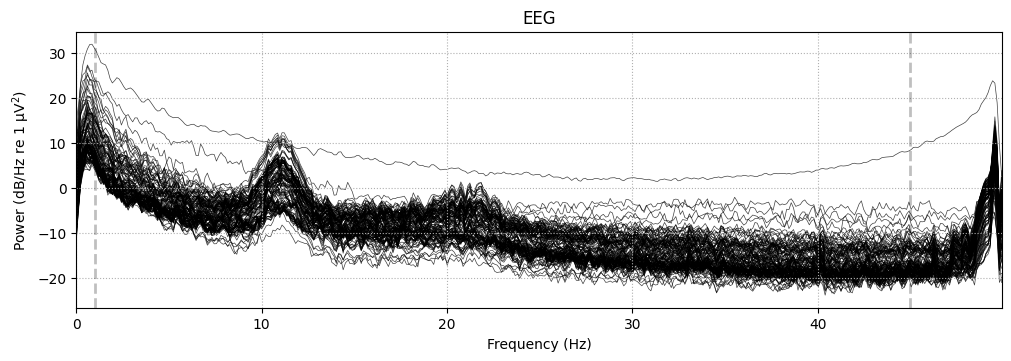

In [4]:
# preprocess the raw data
from src.preprocess import preprocess_raw, epoch_raw

raw_clean = preprocess_raw(raw)

raw_clean.plot(n_channels=20, duration=10, scalings="auto")
raw_clean.compute_psd(fmax = 50).plot()


In [5]:
epochs = epoch_raw(raw_clean, epoch_len=2.0)

print(epochs)
print("Epochs shape:", epochs.get_data().shape)


<Epochs | 149 events (all good), 0 – 1.996 s (baseline off), ~72.9 MiB, data loaded,
 'rest': 149>
Epochs shape: (149, 128, 500)


In [6]:
epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=150e-6)  # conservative threshold
)

print("Before:", len(epochs))
print("After:", len(epochs_clean))


    Rejecting  epoch based on EEG : ['EEG14', 'EEG56']


    Rejecting  epoch based on EEG : ['EEG14']
    Rejecting  epoch based on EEG : ['EEG120']
    Rejecting  epoch based on EEG : ['EEG9', 'EEG14', 'EEG15', 'EEG17', 'EEG21', 'EEG25', 'EEG126']
    Rejecting  epoch based on EEG : ['EEG1', 'EEG8', 'EEG14', 'EEG15', 'EEG17', 'EEG18', 'EEG19', 'EEG21', 'EEG22', 'EEG23', 'EEG25', 'EEG26', 'EEG120', 'EEG126']
    Rejecting  epoch based on EEG : ['EEG1', 'EEG8', 'EEG14', 'EEG15', 'EEG17', 'EEG18', 'EEG21', 'EEG22', 'EEG23', 'EEG25', 'EEG26', 'EEG32', 'EEG120']
    Rejecting  epoch based on EEG : ['EEG25']
    Rejecting  epoch based on EEG : ['EEG48', 'EEG120', 'EEG127']
    Rejecting  epoch based on EEG : ['EEG14']
    Rejecting  epoch based on EEG : ['EEG56', 'EEG66']
    Rejecting  epoch based on EEG : ['EEG14']
    Rejecting  epoch based on EEG : ['EEG25']
    Rejecting  epoch based on EEG : ['EEG56']
    Rejecting  epoch based on EEG : ['EEG14']
    Rejecting  epoch based on EEG : ['EEG14', 'EEG17', 'EEG21']
    Rejecting  epoch based on 

In [8]:
import numpy as np

data = epochs_clean.get_data()  # (n_epochs, n_ch, n_times)
ptp = np.ptp(data, axis = 2)         # peak-to-peak per epoch/channel

print("epochs_clean:", data.shape)
print("Median peak-to-peak (uV):", np.median(ptp) * 1e6)
print("95th percentile peak-to-peak (uV):", np.percentile(ptp, 95) * 1e6)


epochs_clean: (126, 128, 500)
Median peak-to-peak (uV): 22.174607460936777
95th percentile peak-to-peak (uV): 57.989490042396575
